# Install Dependencies

In [1]:
%pip install numpy pandas xgboost tensorflow scikit-learn matplotlib "dask[dataframe]"


# Unzip Data

In [2]:
import zipfile
with zipfile.ZipFile("data.zip","r") as zip_ref:
    zip_ref.extractall(".")

# Load and Preprocess Data
*   Load Data
*   Sort data chronologically and generate lag-based features
*   Handle missing data and outliers


In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import folium

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, Conv1D, Flatten, BatchNormalization
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from folium.plugins import TimestampedGeoJson

# Load datasets
epidemiology = pd.read_csv("epidemiology.csv")
geography = pd.read_csv("geography.csv")

# Convert date to datetime format
epidemiology["date"] = pd.to_datetime(epidemiology["date"])

# Merge datasets on 'key' and 'date'
merged_df = epidemiology.merge(geography, on="location_key", how="left")

# Filter out columns needed
merged_df = merged_df[['date', 'location_key', 'new_confirmed', 'new_deceased',
       'cumulative_confirmed', 'cumulative_deceased', 'latitude', 'longitude']]

# Handle missing data and negative new_confirmed cases
merged_df.dropna(subset=["new_confirmed", "latitude", "longitude", "cumulative_confirmed", "new_deceased", "cumulative_deceased"], inplace=True)
merged_df = merged_df[merged_df["new_confirmed"] >= 0]

# Sort by date is essential for time series analysis
merged_df.sort_values(by="date", inplace=True, ascending=True)

# Create lag features from previous day and week
merged_df["new_confirmed_lag_1"] = merged_df.groupby("location_key")["new_confirmed"].shift(1)
merged_df["new_confirmed_lag_7"] = merged_df.groupby("location_key")["new_confirmed"].shift(7)
merged_df.dropna(subset=["new_confirmed_lag_1", "new_confirmed_lag_7"], inplace=True)

# 2022 Weekly New Cases

In [4]:
year_to_plot = 2022
df = merged_df[merged_df["date"].dt.year == year_to_plot]
df = merged_df[merged_df['location_key'].str[:2] == 'US']

df["week"] = df["date"].dt.to_period("W")

df_weekly = df.groupby(["week"]).agg({
    "latitude": "first", "longitude": "first", "new_confirmed": "sum"
}).reset_index()
df_weekly["week"] = df_weekly["week"].astype(str)
df_weekly["week"] = df_weekly["week"].apply(lambda x: str(x).split("/")[0])
df_weekly["week"] = pd.to_datetime(df_weekly["week"]).dt.strftime("%Y-%m-%dT00:00:00Z")

# Base map centered on first recorded outbreak
m = folium.Map(location=[df_weekly.iloc[0]["latitude"], df_weekly.iloc[0]["longitude"]], zoom_start=1)

# GeoJSON format for time-series animation
features = []
for _, row in df_weekly.iterrows():
    feature = {
        "type": "Feature",
        "geometry": {"type": "Point", "coordinates": [row["longitude"], row["latitude"]]},
        "properties": {
            "time": row["week"],
            "popup": f"Week: {row['week']}\nCases: {row['new_confirmed']}",
            "icon": "circle",
            "iconstyle": {"color": "red", "radius": 8}
        }
    }
    features.append(feature)

# Animated outbreak markers
TimestampedGeoJson({"type": "FeatureCollection", "features": features}, period="P7D", add_last_point=True).add_to(m)

m.save("monthly_cases_map.html")
m


<ipython-input-4-4be37923a06d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["week"] = df["date"].dt.to_period("W")


# Split Test and Training Data
*   Scale and Encode Features




In [5]:
# Scale and Encode features
scaler = MinMaxScaler()
encoder = LabelEncoder()

merged_df["location_key"] = encoder.fit_transform(merged_df["location_key"])

X_scaled = scaler.fit_transform(merged_df.drop(columns=["date", "new_confirmed"]))
y = merged_df["new_confirmed"]

# Splitting data for training
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


#Train XGBoost for Case Predictions
*   Structured learning using gradient boosting



In [6]:
# Train XGBoost Model
xgb_model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=5)
feature_names = list(merged_df.drop(columns=["date", "new_confirmed"]).columns)
xgb_model.fit(X_train, y_train)
xgb_model.get_booster().feature_names = feature_names
xgb_preds = xgb_model.predict(X_test)
print(f"Model R² Score: {xgb_model.score(X_test, y_test)}")


Model R² Score: 0.9055744575370175


#Top-ranking features used by XGBoost

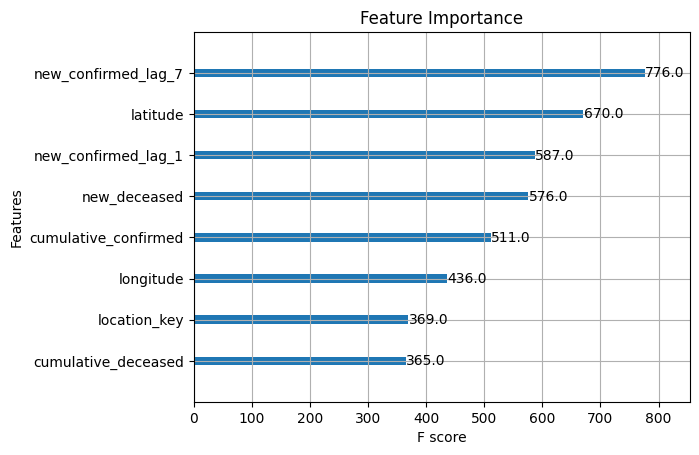

In [7]:
xgb.plot_importance(xgb_model, importance_type="weight", title="Feature Importance")
plt.show()

#Train GRU for Sequential Learning


In [8]:
# Train GRU Model

# XLA Compilation for faster training
tf.config.optimizer.set_jit(True)
set_global_policy("mixed_float16")

# Reshape for GRU input format: (samples, timesteps, features)
X_train_gru = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_gru = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

gru_model = Sequential([
    GRU(50, return_sequences=True, input_shape=(X_train_gru.shape[1], 1),
        activation="tanh",
        recurrent_activation='sigmoid',
        dropout=0,
        recurrent_dropout=0,
        unroll=False,
        use_bias=True,
        reset_after=True,
        ),
    Dropout(0.2),
    GRU(50, activation="tanh",
        recurrent_activation="sigmoid",
        dropout=0,
        recurrent_dropout=0,
        unroll=False,
        use_bias=True,
        reset_after=True,
        ),
    Dropout(0.2),
    Dense(1)
])

# Cast for better computations
X_train_gru = X_train_gru.astype("float32")
X_test_gru = X_test_gru.astype("float32")

optimizer = Adam(learning_rate=0.1)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=0.0001)

# Compile and train model
gru_model.compile(loss="mean_squared_error", optimizer=optimizer)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_gru, y_train)).batch(2048).prefetch(tf.data.AUTOTUNE)

gru_model.fit(train_dataset, epochs=20, validation_data=(X_test_gru, y_test), callbacks=[lr_scheduler])
gru_preds = gru_model.predict(X_test_gru).flatten()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 203s 46ms/step - loss: 92063008.0000 - val_loss: 83347432.0000 - learning_rate: 0.1000
Epoch 2/20
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 199s 46ms/step - loss: 92062240.0000 - val_loss: 83347496.0000 - learning_rate: 0.1000
Epoch 3/20
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 197s 46ms/step - loss: 92062200.0000 - val_loss: 83347656.0000 - learning_rate: 0.1000
Epoch 4/20
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 197s 45ms/step - loss: 92062440.0000 - val_loss: 83347168.0000 - learning_rate: 0.1000
Epoch 5/20
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 197s 45ms/step - loss: 92062440.0000 - val_loss: 83346896.0000 - learning_rate: 0.1000
Epoch 6/20
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 198s 46ms/step - loss: 92062336.0000 - val_loss: 83346608.0000 - learning_rate: 0.1000
Epoch 7/20
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 198s 46ms/step - loss: 92062560.0000 - val_loss: 83346728.0000 - learning_rate: 0.1000
Epoch 8/20
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 198s 46ms/step - loss: 92062272.0000 - val_loss: 833500

# Hybrid Ensemble Prediction
*   Blend structured and sequential models



In [9]:
from sklearn.metrics import r2_score

ensemble_preds = 0.9 * xgb_preds + 0.1 * gru_preds

mae_xgb = mean_absolute_error(y_test, xgb_preds)
mae_gru = mean_absolute_error(y_test, gru_preds)
mae_ensemble = mean_absolute_error(y_test, ensemble_preds)

print(f"XGBoost MAE with Location-Based Lag Features: {mae_xgb:.4f}")
print(f"GRU MAE: {mae_gru:.4f}")
print(f"Hybrid Ensemble MAE: {mae_ensemble:.4f}")

print(f"XGBoost R² Score: {xgb_model.score(X_test, y_test)}")
print(f"GRU R² Score: {gru_model.evaluate(X_test_gru, y_test)}")
print(f"Hybrid Ensemble R² Score: {r2_score(y_test, ensemble_preds)}")

print(f"XGBoost RMSE: {np.sqrt(mae_xgb):.4f}")
print(f"GRU RMSE: {np.sqrt(mae_gru):.4f}")
print(f"Hybrid Ensemble RMSE: {np.sqrt(mae_ensemble):.4f}")


XGBoost MAE with Location-Based Lag Features: 80.5354
GRU MAE: 187.9957
Hybrid Ensemble MAE: 83.2706
XGBoost R² Score: 0.9055744575370175
69332/69332 ━━━━━━━━━━━━━━━━━━━━ 167s 2ms/step - loss: 75322584.0000
GRU R² Score: 82825072.0
Hybrid Ensemble R² Score: 0.8833726361409769
XGBoost RMSE: 8.9741
GRU RMSE: 13.7112
Hybrid Ensemble RMSE: 9.1253


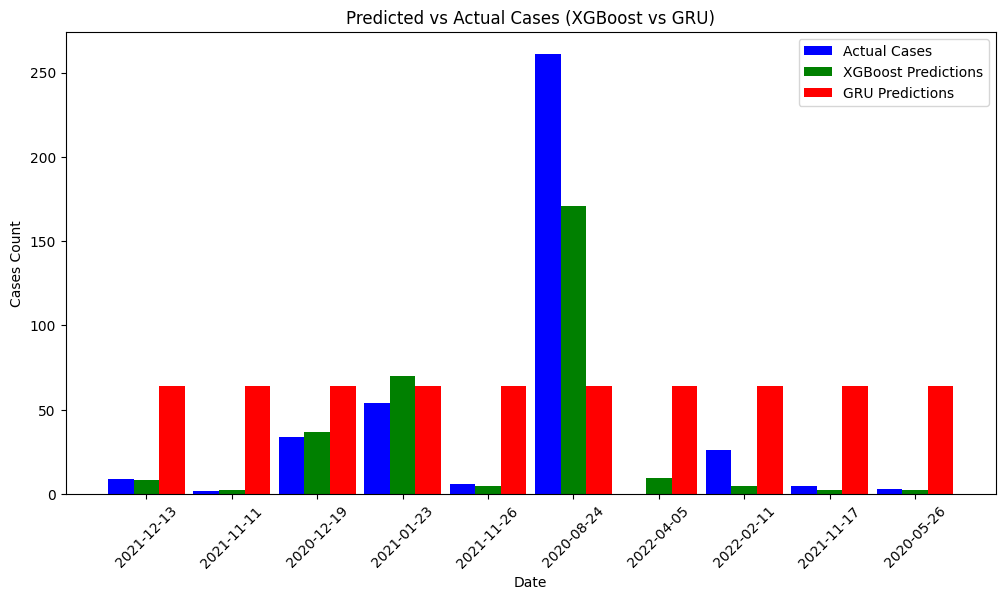

In [10]:
df_actual = y_test.to_frame().merge(merged_df[["date"]], left_index=True, right_index=True)[:10]

df_results = pd.DataFrame({
    "date": df_actual["date"],
    "actual_cases": df_actual["new_confirmed"],
    "xgboost_pred": xgb_preds[:10],
    "gru_pred": gru_preds[:10],
    "ensemble_preds": ensemble_preds[:10]
})

# Define bar width & positions
x_labels = df_results["date"].dt.strftime("%Y-%m-%d")
x = np.arange(len(x_labels))
width = 0.3

plt.figure(figsize=(12, 6))
plt.bar(x, df_results["actual_cases"], width, label="Actual Cases", color="blue")
plt.bar(x + width, df_results["xgboost_pred"], width, label="XGBoost Predictions", color="green")
plt.bar(x + width * 2, df_results["gru_pred"], width, label="GRU Predictions", color="red")

plt.xlabel("Date")
plt.ylabel("Cases Count")
plt.title("Predicted vs Actual Cases (XGBoost vs GRU)")
plt.xticks(x + width, x_labels, rotation=45)
plt.legend()
plt.show()

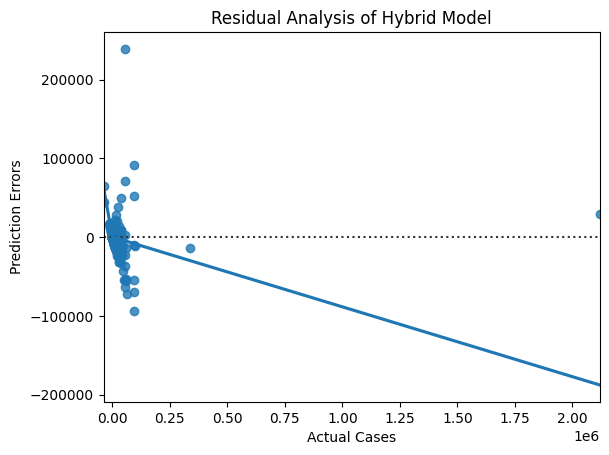

In [11]:
sns.residplot(x=ensemble_preds[:100000], y=y_test.to_frame()[:100000], lowess=True)
plt.title("Residual Analysis of Hybrid Model")
plt.xlabel("Actual Cases")
plt.ylabel("Prediction Errors")
plt.show()